# Adversarial Audio Attack – Experimental Notebook

## Abstract

This notebook investigates the robustness of an audio classification model under adversarial perturbations. We demonstrate the full pipeline from data loading and feature extraction to model training, adversarial attack generation, and evaluation.


This notebook demonstrates:
- Dataset loading
- Feature extraction
- Model training
- Adversarial perturbation
- Evaluation under attack

## Outline
1. Setup & Dependencies
2. Dataset
3. Data Preprocessing
4. Feature Extraction
5. Dataset Loading & Label Encoding
6. Model Architecture
7. Training & Evaluation
8. Model Explainability
10. Live Simulation


## Section 1 – Setup & Dependencies

First, we need to get the data into the Colab environment. We will use gdown to pull the file directly from Google Drive and unzip to extract it.

### 1.1 Environment Setup

In [5]:
# Install necessary libraries
!pip install -q gdown librosa matplotlib seaborn scikit-learn tensorflow

### 1.2 Imports

In [6]:
import os
import glob
import zipfile
import random

import numpy as np

import librosa
import librosa.display

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import gdown
import IPython.display as ipd
from google.colab import files

## Section 2 – Dataset

This section downloads and prepares the dataset.
The dataset is organized by split and class folders.

In [7]:
# 1. Download the dataset
# The ID is the part of the URL after 'd/' and before '/view'
file_id = '1qOrJCCzrl6-PCqlB-8Li5TDtxwxhBG05'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'dataset.zip'

print("Downloading dataset...")
gdown.download(url, output, quiet=False)

# 2. Unzip the dataset
print("Unzipping...")
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('.')
print("Done! Dataset extracted.")

Downloading...
From (original): https://drive.google.com/uc?id=1qOrJCCzrl6-PCqlB-8Li5TDtxwxhBG05
From (redirected): https://drive.google.com/uc?id=1qOrJCCzrl6-PCqlB-8Li5TDtxwxhBG05&confirm=t&uuid=c069a178-5ebd-4ec4-87ba-874833bf9ec0
To: /content/dataset.zip
100%|██████████| 1.92G/1.92G [00:18<00:00, 104MB/s]


Unzipping...
Done! Dataset extracted.


## Section 3: Data Preprocessing

Before training, raw audio recordings must be standardized to ensure temporal consistency across samples.
This stage operates exclusively in the **waveform domain** and prepares the audio for downstream feature extraction.

### Smart Alignment (Temporal Synchronization)

A critical challenge in acoustic analysis is temporal misalignment caused by variable pre-signal silence.
To ensure valid comparisons ("apples to apples"), we apply a deterministic synchronization procedure:

* **Peak Detection:**  
  The index of the maximum absolute amplitude is detected, corresponding to the dominant acoustic event (chirp/beep).

* **Temporal Anchoring:**  
  A fixed extraction window begins **0.2 seconds prior** to the detected peak.

* **Fixed-Length Cropping:**  
  The signal is cropped or zero-padded to a constant duration of 2.0 seconds.

### Resulting Stability

By enforcing strict temporal alignment, the primary sound event appears at an identical position in every sample.
This prevents the model from learning spurious cues such as recording start time and instead encourages learning from
the **reverberation tail**, which encodes room-specific acoustic characteristics.

In [8]:
# --- CONFIGURATION ---
SAMPLE_RATE = 16000
DURATION = 2.0
PRE_BUFFER = 0.2
N_MELS = 128

In [9]:
def preprocess_audio(file_path: str) -> np.ndarray | None:
    """
    Loads and preprocesses raw audio.
    Returns a fixed-length waveform aligned to the peak.
    """
    try:
        # 1. Load Audio (mono)
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

        # Safety check
        if len(audio) == 0 or np.max(np.abs(audio)) == 0:
            return None

        # 2. Dynamic alignment (find beep)
        peak_index = np.argmax(np.abs(audio))

        # 3. Window definition
        start_index = max(0, peak_index - int(PRE_BUFFER * SAMPLE_RATE))
        target_length = int(DURATION * SAMPLE_RATE)
        end_index = start_index + target_length

        # 4. Crop
        audio_crop = audio[start_index:end_index]

        # 5. Padding
        if len(audio_crop) < target_length:
            padding = target_length - len(audio_crop)
            audio_crop = np.pad(audio_crop, (0, padding), 'constant')

        return audio_crop

    except Exception as e:
        print(f"Preprocessing error in {file_path}: {e}")
        return None

## Section 4: Feature Extraction

Once temporal alignment is achieved, the standardized waveform is converted into a numerical representation suitable for convolutional neural networks.

### Log-Mel Spectrogram Representation

* **Raw Audio Limitations:**  
  Raw waveforms represent amplitude over time, making it difficult for CNNs to directly extract structured acoustic patterns from a 1D signal.

* **Spectrogram Advantage:**  
  The Log-Mel Spectrogram provides a time–frequency representation that emphasizes perceptually meaningful frequency bands.

* **Environmental Encoding:**  
  This representation acts as an **acoustic fingerprint**, capturing how different frequencies decay over time due to room geometry and material properties.

### Output

The resulting Log-Mel Spectrogram serves as the 2D input to the CNN model, enabling spatial pattern learning across both time and frequency axes.

This representation is later used as input to the convolutional neural network.

In [10]:
def extract_log_mel(audio_waveform):
    """
    Converts a waveform into a log-mel spectrogram.
    """
    try:
        mels = librosa.feature.melspectrogram(
            y=audio_waveform,
            sr=SAMPLE_RATE,
            n_mels=N_MELS
        )
        log_mels = librosa.power_to_db(mels, ref=np.max)
        return log_mels

    except Exception as e:
        print(f"Feature extraction error: {e}")
        return None

def extract_features(file_path):
    audio = preprocess_audio(file_path)
    if audio is None:
        return None
    return extract_log_mel(audio)

### Alignment Verification
Below we visualize a randomly selected log-mel spectrogram to verify temporal consistency.


## Section 5 – Dataset Loading & Label Encoding

In this section, we construct the final datasets used for training, validation, and testing.
The directory structure (`dataset → split → room → audio file`) is traversed to load pre-extracted features, assign labels, and format tensors for CNN input.


### Dataset Construction Logic

1. **Directory Traversal:**  
   The script iterates over the Train, Validation, and Test splits, recursively scanning class-specific folders.

2. **Data Integrity Filtering:**  
   If feature extraction fails for a given file (e.g., silent or corrupted audio), the sample is automatically skipped.  
   This defensive check prevents invalid tensors and avoids downstream numerical issues during training.

3. **Label Assignment:**  
   Ground-truth labels are inferred directly from the parent directory name (e.g., `room_01`), ensuring a consistent and reproducible labeling scheme.


### Label Encoding

Class labels are converted from string identifiers to numerical representations using one-hot encoding.
This allows the model to perform multi-class classification using a categorical cross-entropy loss function.


### Tensor Formatting for CNN Input

The extracted log-mel spectrograms are reshaped to include an explicit channel dimension, resulting in tensors of shape:

(Height, Width, 1)

This additional dimension is required by 2D convolutional layers, which interpret the spectrogram as a single-channel (grayscale) image.

In [11]:
# --- CONFIGURATION ---
# CHANGE THIS to the folder you want to train on (e.g., 'dataset_noisy' or 'dataset_fusion')
DATASET_ROOT = 'dataset_noisy'

def load_dataset(split_name):
    """
    Iterates through folders and loads data for a specific split (train/val/test).
    Skips files that fail feature extraction.
    """
    features = []
    labels = []

    # Path pattern: dataset_folder/train/room_01/*.wav
    search_path = os.path.join(DATASET_ROOT, split_name, '*', '*.wav')
    files = glob.glob(search_path)

    print(f"📂 Scanning {len(files)} files for {split_name} set...")

    for file in files:
        # Extract features
        data = extract_features(file)

        # Check if extraction succeeded
        if data is not None:
            features.append(data)

            # Extract label (e.g., 'room_01')
            label = os.path.basename(os.path.dirname(file))
            labels.append(label)
        else:
            print(f"⚠️ Skipped corrupted file: {file}")

    print(f"✅ Loaded {len(features)} valid samples.")
    return np.array(features), np.array(labels)

# --- EXECUTION ---
# 1. Load splits
X_train, y_train_raw = load_dataset('train')
X_val, y_val_raw = load_dataset('val')
X_test, y_test_raw = load_dataset('test')

# 2. Encode labels
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train_raw))
# Use 'transform' for val/test to ensure consistent mapping
y_val = to_categorical(le.transform(y_val_raw))
y_test = to_categorical(le.transform(y_test_raw))

# 3. Add Channel Dimension for CNN
# Input shape becomes: (Batch, Height, Width, 1)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"\nTraining Shape: {X_train.shape}")
print(f"Classes: {le.classes_}")

📂 Scanning 16290 files for train set...
✅ Loaded 16290 valid samples.
📂 Scanning 3480 files for val set...
✅ Loaded 3480 valid samples.
📂 Scanning 3480 files for test set...
✅ Loaded 3480 valid samples.

Training Shape: (16290, 128, 63, 1)
Classes: ['room_01' 'room_02' 'room_03' 'room_04' 'room_05' 'room_06' 'room_07'
 'room_08' 'room_09']


### Section 5.1 – Sanity Check: Alignment Verification

This verification step is particularly important when operating on noisy data, as excessive background noise may interfere with peak detection and temporal alignment.

Before we trust the data, we must verify that our "Smart Alignment" works even with the added noise.
We will visualize the **Full Spectrogram** and draw a **Red Box** around the area the model will actually see.

**What to verify:**
1.  **Alignment:** The Red Box should start slightly before the loudest "Chirp."
2.  **Noise Level:** If the box is jumping to a random spot in the background static, the noise is too loud, and our peak detection failed.
3.  **Audio Quality:** Listen to the clip to ensure the echo is still audible through the noise.

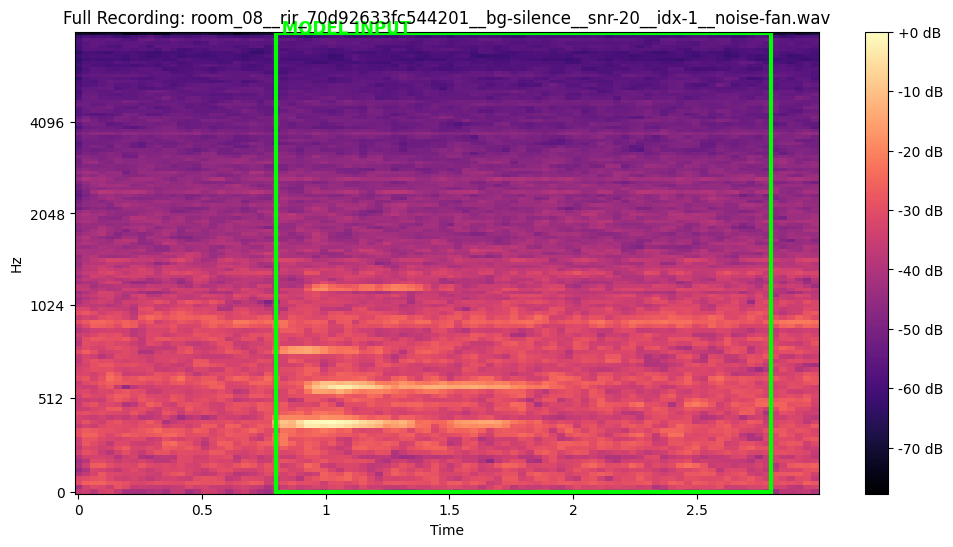

🔊 Listening to the file...


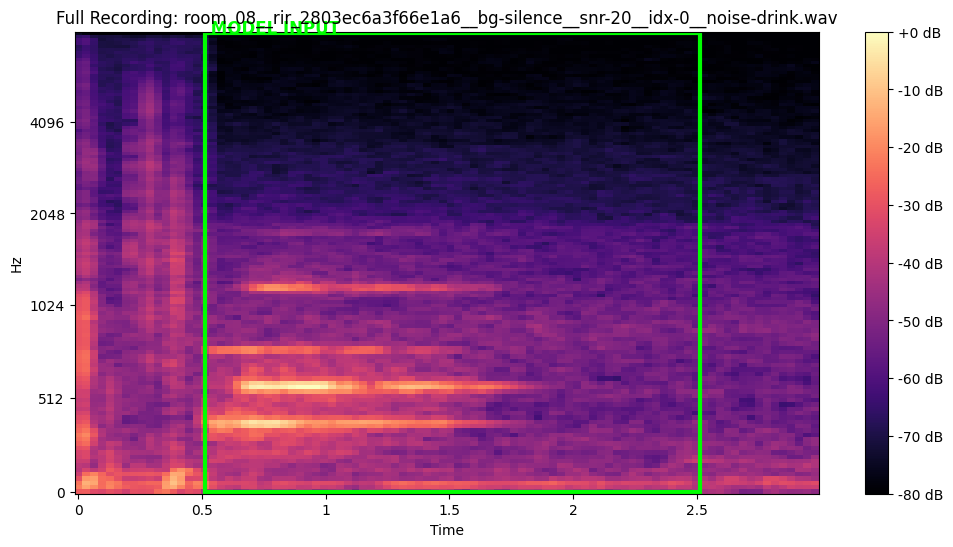

🔊 Listening to the file...


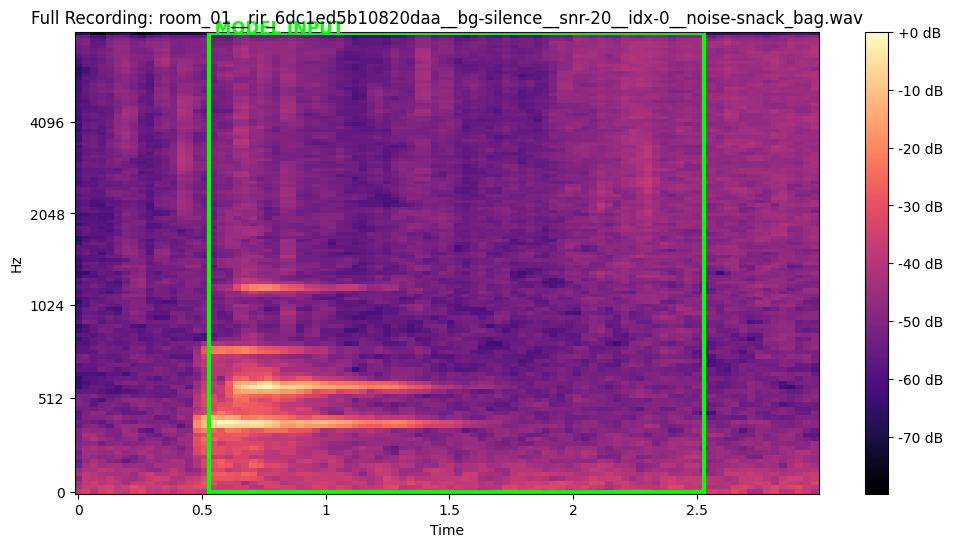

🔊 Listening to the file...


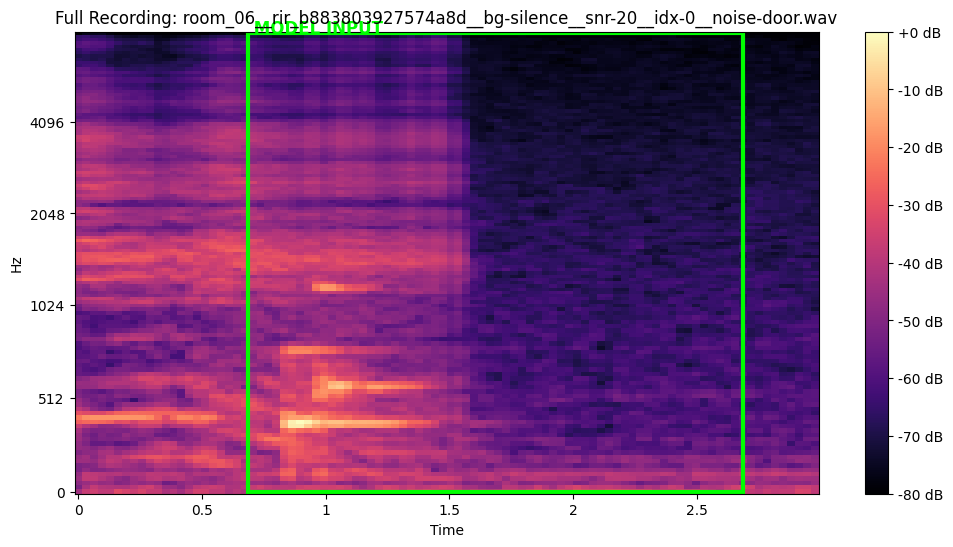

🔊 Listening to the file...


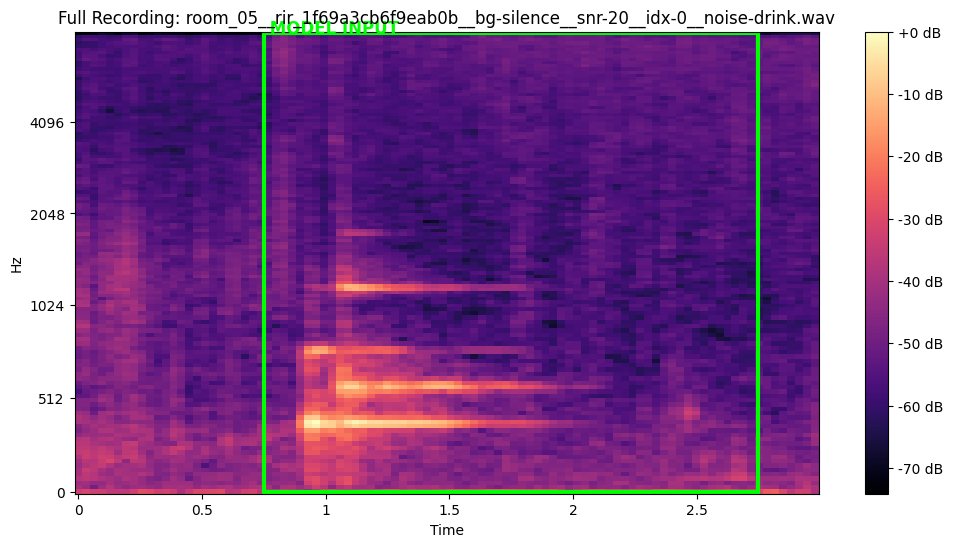

🔊 Listening to the file...


In [12]:
def verify_clipping_logic():
    # 1. Pick a random file from the NOISY dataset
    search_path = os.path.join('dataset_noisy', '**', '*.wav')
    files = glob.glob(search_path, recursive=True)

    if not files:
        print("⚠️ No files found. Check your path.")
        return

    random_file = random.choice(files)

    # 2. Load the Full Audio
    audio, sr = librosa.load(random_file, sr=16000, mono=True)

    # --- RE-RUNNING THE LOGIC TO FIND COORDINATES ---
    peak_index = np.argmax(np.abs(audio))
    start_sample = max(0, peak_index - int(0.2 * sr)) # 0.2s Pre-buffer
    end_sample = start_sample + int(2.0 * sr)         # 2.0s Duration

    # Convert samples to Time (Seconds) for plotting
    start_time = start_sample / sr
    end_time = end_sample / sr
    duration = end_time - start_time

    # 3. Generate Full Spectrogram for Context
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    log_mels = librosa.power_to_db(mels, ref=np.max)

    # 4. Visualization
    plt.figure(figsize=(12, 6))

    # Display Full Spectrogram
    librosa.display.specshow(log_mels, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Full Recording: {os.path.basename(random_file)}")

    # Add the Red Box (The "Crop" Zone)
    ax = plt.gca()
    # Create a Rectangle patch
    # (x, y), width, height, edgecolor, facecolor
    rect = patches.Rectangle(
        (start_time, 0),         # (x, y) - Start Time, 0 Hz
        duration,                # width - 2.0 Seconds
        sr/2,                    # height - Full Frequency Range (Nyquist)
        linewidth=3,
        edgecolor='lime',        # Green or Red border
        facecolor='none'         # Transparent inside
    )
    ax.add_patch(rect)

    plt.text(start_time, 8000, ' MODEL INPUT ', color='lime', fontweight='bold', fontsize=12)
    plt.show()

    # 5. Listen
    print("🔊 Listening to the file...")
    ipd.display(ipd.Audio(random_file))

# --- RUN THE TEST ---
verify_clipping_logic()
verify_clipping_logic()
verify_clipping_logic()
verify_clipping_logic()
verify_clipping_logic()

## Section 6 – Model Architecture


We employ a Convolutional Neural Network (CNN). Even though the source data is audio, the spectrogram allows us to treat this as a **Visual Classification Task**.



### How it works:
* **The Input:** A 128-pixel tall "image" of the sound.
* **The Task:** The CNN does not "listen"; it looks for **shapes**. Specifically, it hunts for the unique "texture" of the echo's decay while ignoring the chaotic "snow" of the background noise.

### Architecture Upgrades (for Noise Robustness):
We upgraded the standard model to a **4-Block Architecture** to handle the noisy dataset:
1.  **Deep Feature Extraction:** We use 4 blocks of Convolution to aggressively filter out the added background noise and isolate the room's signal.
2.  **L2 Regularization:** A mathematical "penalty" applied to the dense layer. It forces the model to ignore small, random pixels (noise) and focus only on strong, consistent patterns (the echo).
3.  **Dropout (0.4):** Randomly disables 40% of the neurons during training, preventing the model from memorizing specific noise artifacts.

In [13]:
input_shape = X_train.shape[1:]
num_classes = len(le.classes_)

model = Sequential([
    # --- Block 1: Low Level Features ---
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # --- Block 2: Mid Level Features ---
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # --- Block 3: High Level Features ---
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # --- Block 4: Abstract Features ---
    # Essential for 128-mel inputs with noise.
    # Reduces the feature map size to prevent overfitting on the background noise.
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # --- Classifier ---
    Flatten(),

    # L2 Regularization helps the model ignore random noise pixels
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 63, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 7, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 7, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 7, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177,481 (4.49 MB)

 Trainable params: 1,176,521 (4.49 MB)

 Non-trainable params: 960 (3.75 KB)

## Section 7: Training & Evaluation

We use an adaptive training strategy to handle the complexity of the noisy dataset.

### 1. Smart Callbacks
Training on noisy data requires patience and precision. We use two specific tools:
* **ReduceLROnPlateau ("The Gear Shifter"):** If the validation performance (validation loss) plateaus for 3 epochs, we reduce the learning rate by 50%. This allows the model to take smaller, more precise steps to find the optimal solution.
* **EarlyStopping ("The Safety Net"):** If the model stops improving for 10 epochs, training stops automatically to prevent overfitting (memorizing the noise).

### 2. Diagnostic Visualization
Beyond simple accuracy, we utilize a **Confusion Matrix**.
* **Why?** In a noisy environment, two rooms might sound similar (e.g., both have AC hum).
* **The Matrix:** This chart shows us exactly *which* rooms are being confused with each other, allowing us to debug specific "problem rooms."

🚀 Starting training with Noise Resilience...
Epoch 1/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.3353 - loss: 2.1853 - val_accuracy: 0.6546 - val_loss: 1.2362 - learning_rate: 0.0010
Epoch 2/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5635 - loss: 1.2816 - val_accuracy: 0.7417 - val_loss: 0.9236 - learning_rate: 0.0010
Epoch 3/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6419 - loss: 0.9811 - val_accuracy: 0.7560 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 4/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7352 - loss: 0.7902 - val_accuracy: 0.6224 - val_loss: 1.1453 - learning_rate: 0.0010
Epoch 5/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8141 - loss: 0.5990 - val_accuracy: 0.8178 - val_loss: 0.6112 - learning_rate: 0.0010
Epoch 6/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8560 - loss: 0.5132 - val_accuracy: 0.8695 - val_loss: 0.5112 - learning_rate: 0.0010
Epoch 7/100
510/510 ━━━━━━━━━━

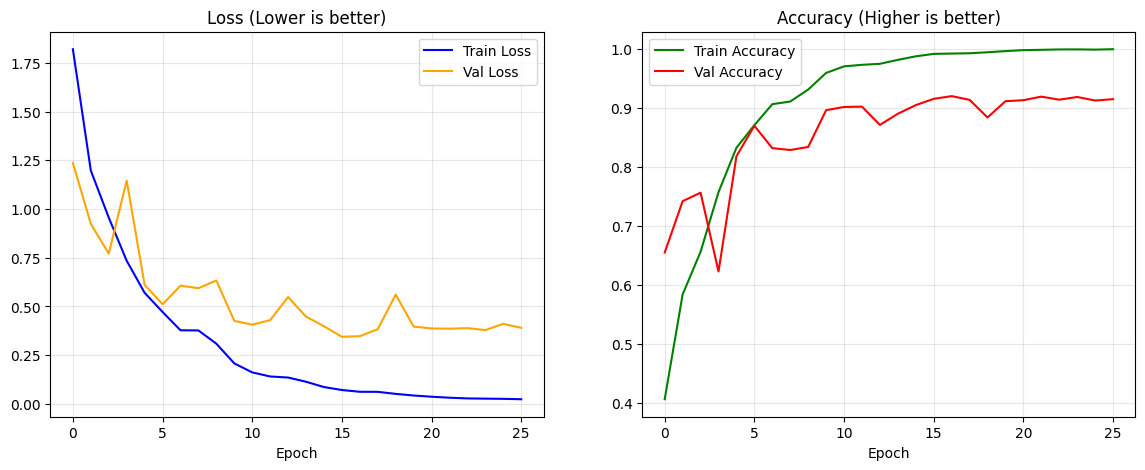

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


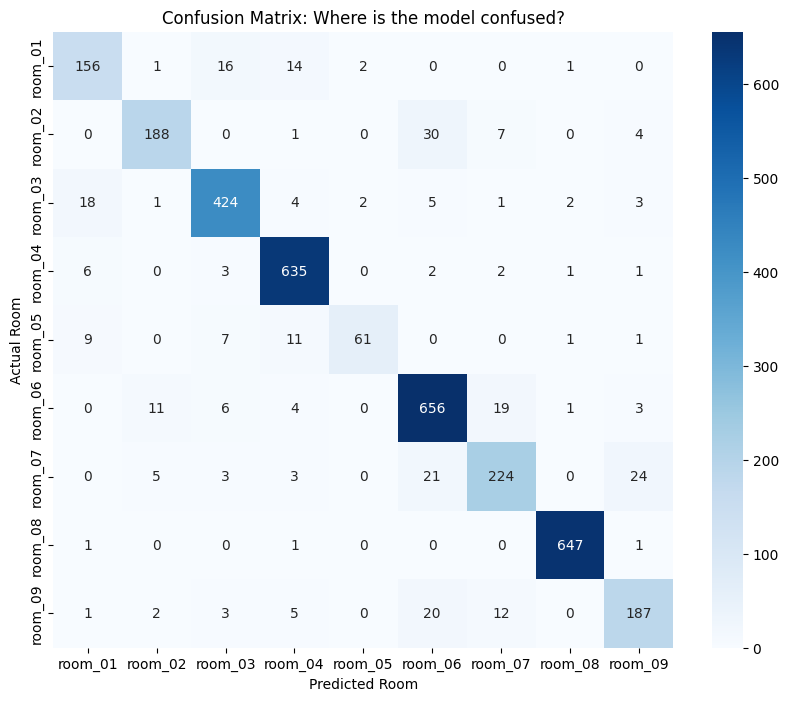


--- Final Test Set Evaluation ---
🏆 Final Test Accuracy: 91.32%


In [14]:
# --- 1. SMART CALLBACKS (UNCHANGED) ---
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# --- 2. TRAINING ---
print("🚀 Starting training with Noise Resilience...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stop]
)

# --- 3. VISUALIZATION & DIAGNOSTICS ---
# A. Loss & Accuracy Curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss (Lower is better)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Accuracy (Higher is better)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# B. The "Truth Table" (Confusion Matrix)
# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual Room')
plt.xlabel('Predicted Room')
plt.title('Confusion Matrix: Where is the model confused?')
plt.show()

# Final Score
print("\n--- Final Test Set Evaluation ---")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🏆 Final Test Accuracy: {test_acc*100:.2f}%")

In [15]:
# Save as a single file
model.save('room_classifier.keras')

# Download to your computer
files.download('room_classifier.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Section 8: Model Explainability (Gradient-Based Saliency Analysis)

To ensure our model is robust and not merely "guessing" based on background artifacts, we perform a **Saliency Analysis**. We generate a "Heatmap" for one random example from every room class to visualize exactly which features drive the model's decision.

### 1. What is a Saliency Map?
A Saliency Map visualizes the gradients of the model's prediction with respect to the input image. In simple terms, it answers the question:
> *"If I change this specific pixel by a tiny amount, how much does the model's confidence change?"*

* **High Gradient (Red/Yellow):** This pixel is **critical** for the decision.
* **Low Gradient (Blue/Black):** The model **ignores** this area.

Note: Saliency maps provide a *local sensitivity analysis* and should be interpreted qualitatively rather than as a definitive causal explanation.


### 2. How to Read the Results
We will generate a grid with **One Row per Room**.
* **Left Column (The Input):** The aligned spectrogram showing the "Beep" (vertical line) and the "Echo" (horizontal trail).
* **Right Column (The Heatmap):** The model's focus.

Use the table below to interpret the quality of your model:

| Result Type | Visual Pattern | Interpretation |
| :--- | :--- | :--- |
| **✅ Success (Good Physics)** | Bright spots concentrate on the **Curved Echo Tail**. | The model is correctly analyzing the room's unique reverberation decay. |
| **⚠️ Warning (Bias)** | Bright spots appear **only** on the initial vertical line. | The model is focusing on the loud "Beep" rather than the room acoustics. |
| **❌ Failure (Overfitting)** | Bright spots are scattered randomly in the **empty background**. | The model is memorizing the specific "static" or noise patterns (e.g., rain drops) instead of the signal. |

### 3. Execution
The following function iterates through every class, extracts a valid test sample, and compares the input against the saliency map.

🔍 Generating Saliency Maps for 9 rooms...


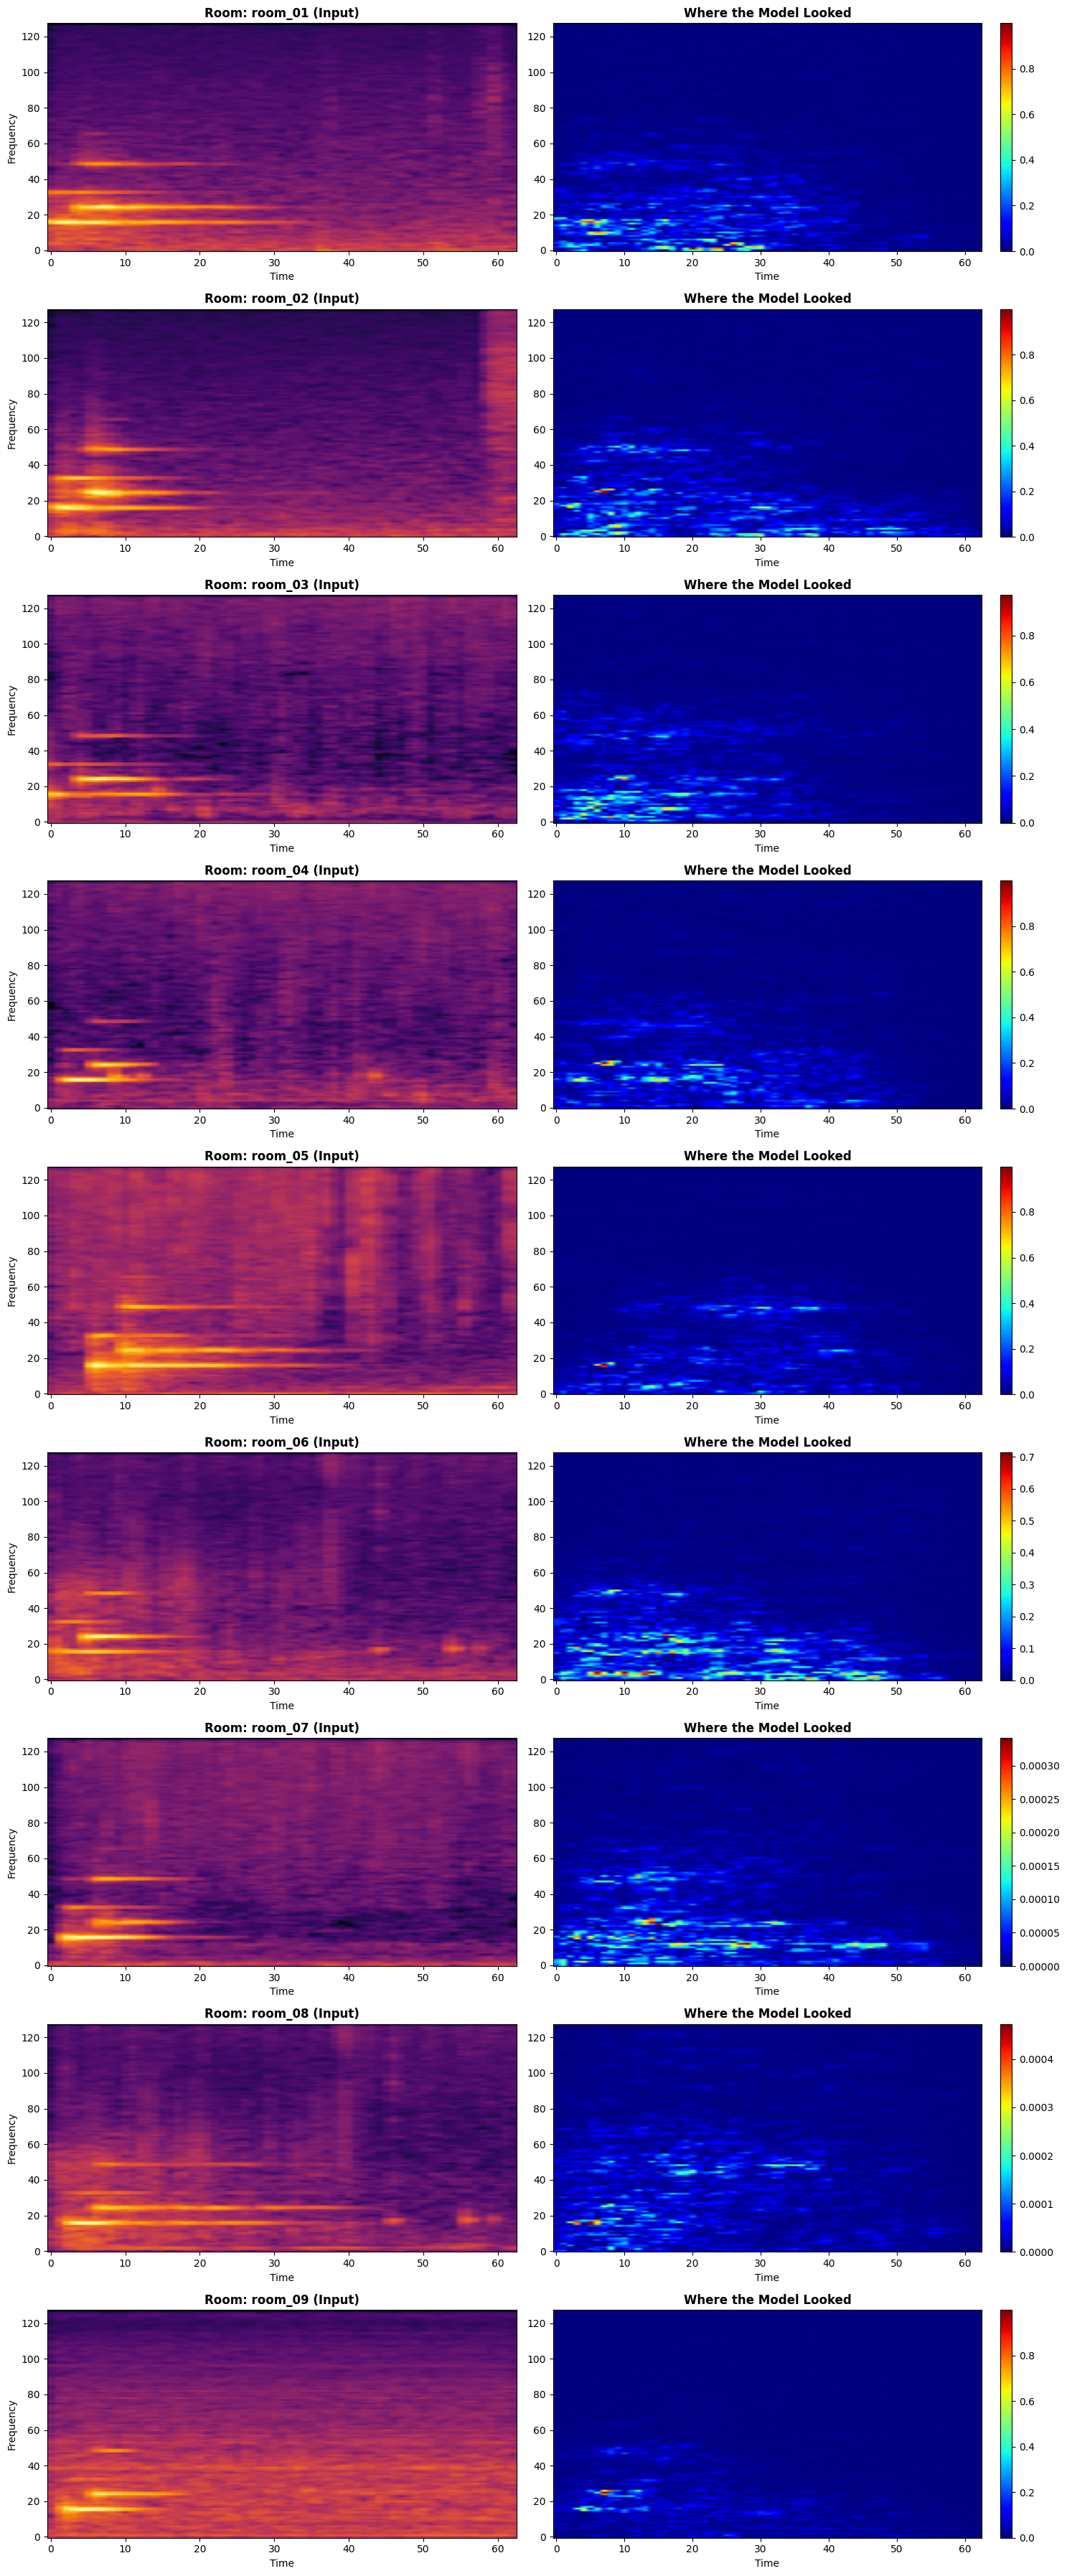

In [16]:
def visualize_saliency(model, spectrogram_input):
    """
    Computes the saliency map for a given spectrogram input.
    """
    # 1. Prepare input: Convert to tensor and add batch dimension (1, 128, Time, 1)
    img_tensor = tf.convert_to_tensor(spectrogram_input)
    img_tensor = tf.expand_dims(img_tensor, 0)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)

        # Get the score for the highest predicted class
        top_class = tf.argmax(preds[0])
        top_score = preds[0, top_class]

    # 2. Compute gradients of the top score with respect to the input pixels
    grads = tape.gradient(top_score, img_tensor)

    # 3. Process gradients: Take absolute values and the maximum across channels
    dgrad_abs = tf.math.abs(grads)
    dgrad_max = np.max(dgrad_abs, axis=3)[0]

    # 4. Normalize between 0 and 1 for clear visualization
    arr_min, arr_max = np.min(dgrad_max), np.max(dgrad_max)
    grad_visual = (dgrad_max - arr_min) / (arr_max - arr_min + 1e-8)

    return grad_visual

def plot_saliency_per_class(model, X_test, y_test, label_encoder):
    """
    Plots the Original Spectrogram vs. Saliency Map for ONE example of EACH class.
    """
    # Convert one-hot encoded labels back to integers for easy searching
    y_test_integers = np.argmax(y_test, axis=1)
    classes = label_encoder.classes_
    n_classes = len(classes)

    # Create a figure with rows = num_classes, cols = 2
    fig, axes = plt.subplots(n_classes, 2, figsize=(15, 4 * n_classes))

    print(f"🔍 Generating Saliency Maps for {n_classes} rooms...")

    for i, class_name in enumerate(classes):
        # 1. Find the first sample in the test set that belongs to this class
        indices = np.where(y_test_integers == i)[0]

        if len(indices) == 0:
            print(f"⚠️ No test samples found for {class_name}")
            continue

        # Pick the first one (or use random.choice(indices) for variety)
        idx = indices[0]
        sample_input = X_test[idx]

        # 2. Compute Saliency Map (using the function we defined earlier)
        saliency = visualize_saliency(model, sample_input)

        # 3. Plot Original Spectrogram (Left Column)
        ax_orig = axes[i][0] if n_classes > 1 else axes[0]
        ax_orig.imshow(sample_input.squeeze(), aspect='auto', origin='lower', cmap='inferno')
        ax_orig.set_title(f"Room: {class_name} (Input)", fontsize=12, fontweight='bold')
        ax_orig.set_ylabel("Frequency")
        ax_orig.set_xlabel("Time")

        # 4. Plot Saliency Map (Right Column)
        ax_sal = axes[i][1] if n_classes > 1 else axes[1]
        im = ax_sal.imshow(saliency, aspect='auto', origin='lower', cmap='jet') # 'jet' or 'hot' highlights peaks well
        ax_sal.set_title(f"Where the Model Looked", fontsize=12, fontweight='bold')
        ax_sal.set_xlabel("Time")

        # Add a small colorbar to the saliency map
        plt.colorbar(im, ax=ax_sal, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# --- RUN IT ---
plot_saliency_per_class(model, X_test, y_test, le)

## Section 9: Live Simulation (5 Independent Test Runs)

Finally, we test the model in a "Live" scenario.
We will randomly select **5 different audio files** from the Test Set that the model has never seen before.

For each file, we will:
1.  **Listen** to the audio (to hear the noise/room).
2.  **Process** it through the pipeline (Alignment + Spectrogram).
3.  **Predict** the room.
4.  **Compare** the prediction against the ground truth.

This simulates how the system would perform in production when receiving a stream of unknown audio clips.

Each prediction is performed in a **single-shot inference mode**, without batching or temporal smoothing, mimicking a real-time deployment constraint.

In [17]:
def simulate_live_prediction(num_simulations=5):
    print(f"🚀 Starting {num_simulations} Live Simulations...\n")

    # 1. Load all potential test files
    # Uses DATASET_ROOT to ensure we look in the 'dataset_v2_noisy' folder
    search_path = os.path.join(DATASET_ROOT, 'test', '*', '*.wav')
    test_files = glob.glob(search_path)

    if not test_files:
        print("⚠️ Error: No files found in the test folder.")
        return

    for i in range(num_simulations):
        print(f"\n📢 --- Simulation {i+1} / {num_simulations} ---")

        # 2. Pick a random file
        random_file = random.choice(test_files)
        true_room = os.path.basename(os.path.dirname(random_file))

        # 3. Play Audio
        print(f"🎤 File: {os.path.basename(random_file)}")
        print(f"🏠 Real Room: {true_room}")
        ipd.display(ipd.Audio(random_file))

        # 4. Preprocess (Safety Check included)
        spec = extract_features(random_file)

        if spec is None:
            print("⚠️ Skipped: File was corrupted or silent.")
            continue

        # Reshape: (1, 128, Time, 1)
        model_input = spec[np.newaxis, ..., np.newaxis]

        # 5. Prediction
        prediction_probs = model.predict(model_input, verbose=0)
        predicted_index = np.argmax(prediction_probs)
        predicted_room = le.classes_[predicted_index]
        confidence = prediction_probs[0][predicted_index] * 100

        # 6. Result Display
        if predicted_room == true_room:
            print(f"✅ PREDICTION:   {predicted_room}")
        else:
            print(f"❌ PREDICTION:   {predicted_room} (Mistake)")

        print(f"📊 CERTAINTY:    {confidence:.2f}%")

# --- RUN IT ---
simulate_live_prediction(5)

🚀 Starting 5 Live Simulations...


📢 --- Simulation 1 / 5 ---
🎤 File: room_06__rir_6239eaf1faa15c77__bg-silence__snr-20__idx-0__noise-snack_bag.wav
🏠 Real Room: room_06


✅ PREDICTION:   room_06
📊 CERTAINTY:    100.00%

📢 --- Simulation 2 / 5 ---
🎤 File: room_04__rir_3983ea72bbd2bab2__bg-silence__snr-20__idx-0__noise-sneeze.wav
🏠 Real Room: room_04


✅ PREDICTION:   room_04
📊 CERTAINTY:    100.00%

📢 --- Simulation 3 / 5 ---
🎤 File: room_04__rir_cbd801207e5f9b7e__bg-silence__snr-20__idx-1__noise-sneeze.wav
🏠 Real Room: room_04


✅ PREDICTION:   room_04
📊 CERTAINTY:    100.00%

📢 --- Simulation 4 / 5 ---
🎤 File: room_04__rir_9cd0d7cfb14fa4c8__bg-silence__snr-20__idx-1__noise-sneeze.wav
🏠 Real Room: room_04


✅ PREDICTION:   room_04
📊 CERTAINTY:    100.00%

📢 --- Simulation 5 / 5 ---
🎤 File: room_02__rir_916aa1faea6aa8ac__bg-silence__snr-20__idx-0__noise-drink.wav
🏠 Real Room: room_02


✅ PREDICTION:   room_02
📊 CERTAINTY:    99.99%
